<a href="https://colab.research.google.com/github/KoreTane/An-lise-GLP/blob/main/An%C3%A1lisePre%C3%A7oGLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pyspark
#!pip install folium geopandas
#!pip install requests

In [2]:
from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import month, count, avg, sum, to_date
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

drive.mount('/content/drive')

spark = SparkSession.builder \
    .appName("Análise de Preços do GLP") \
    .getOrCreate()

# Caminho para a pasta no Google Drive onde os arquivos Parquet estão armazenados
#(convertemos anteriormente do formato CVS => parquet para melhoramos a eficiência de armazenamento e a velocidade de leitura
# permitindo análises mais rápidas e economizando espaço em disco)

parquet_folder_path = '/content/drive/My Drive/1dhA5CNHrywBWHxOgPRyLalCBmNVbCLof/'

# Carregando o arquivo Excel
localizacao_df = pd.read_excel('/content/drive/My Drive/1dhA5CNHrywBWHxOgPRyLalCBmNVbCLof/BR_Localidades.xlsx')
localizacao_df = spark.createDataFrame(localizacao_df)

# Lista de arquivos Parquet
parquet_files = [
    'glp2023-01.parquet',
    'glp2023-02.parquet',
    'glp2024-01.parquet',
    'precosglp2024-07.parquet',
    'precosglp2024-08.parquet'
]

parquet_dataframes = {
    file: spark.read.parquet(f'{parquet_folder_path}{file}')
    for file in parquet_files
}

union_df = (
    parquet_dataframes['glp2023-01.parquet']
    .union(parquet_dataframes['glp2023-02.parquet'])
    .union(parquet_dataframes['glp2024-01.parquet'])
    .union(parquet_dataframes['precosglp2024-07.parquet'])
    .union(parquet_dataframes['precosglp2024-08.parquet'])
)
union_df = union_df.withColumn("id_venda", F.monotonically_increasing_id())


colunas = ['id_venda'] + [col for col in union_df.columns if col != 'id_venda']
union_df = union_df.select(colunas)

print("Dados do DataFrame unido:")
union_df.printSchema()

union_df.describe().show()

union_df.show(10, truncate=False)

localizacao_df.printSchema()

localizacao_df.describe().show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dados do DataFrame unido:
root
 |-- id_venda: long (nullable = false)
 |-- Regiao - Sigla: string (nullable = true)
 |-- Estado - Sigla: string (nullable = true)
 |-- Municipio: string (nullable = true)
 |-- Revenda: string (nullable = true)
 |-- CNPJ da Revenda: string (nullable = true)
 |-- Nome da Rua: string (nullable = true)
 |-- Numero Rua: string (nullable = true)
 |-- Complemento: string (nullable = true)
 |-- Bairro: string (nullable = true)
 |-- Cep: string (nullable = true)
 |-- Produto: string (nullable = true)
 |-- Data da Coleta: string (nullable = true)
 |-- Valor de Venda: string (nullable = true)
 |-- Valor de Compra: string (nullable = true)
 |-- Unidade de Medida: string (nullable = true)
 |-- Bandeira: string (nullable = true)

+-------+--------------------+--------------+--------------+----------+--------------------+-------------------+-

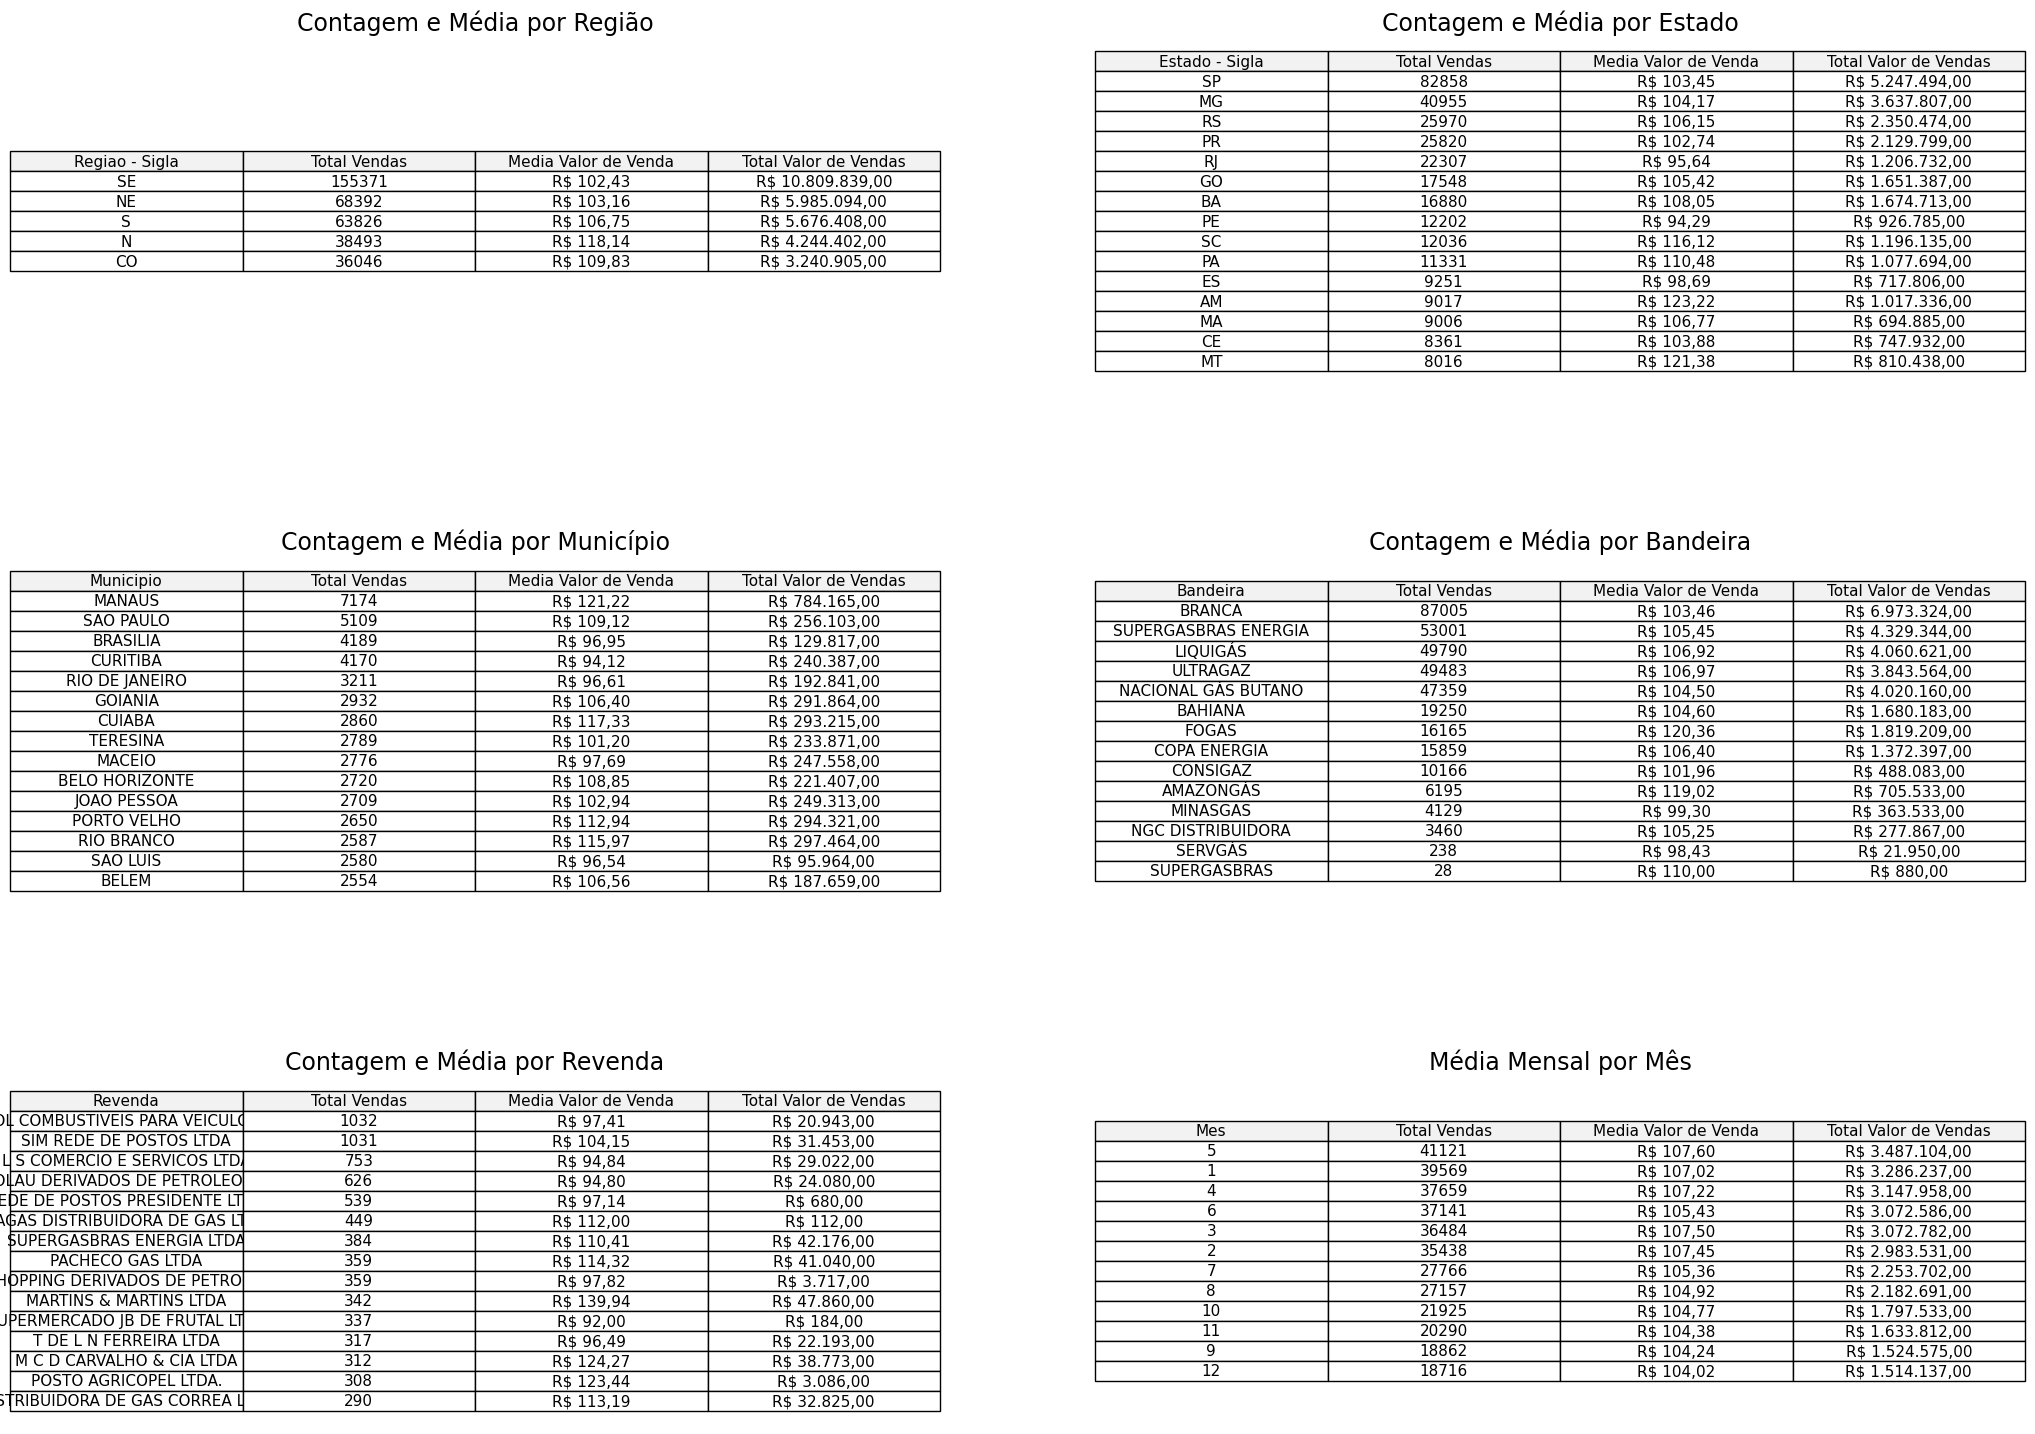

In [3]:
# Convertendo a coluna 'Data da Coleta' para o tipo de data
union_df = union_df.withColumn("Data da Coleta", to_date(union_df["Data da Coleta"], "dd/MM/yyyy"))

# Agrupando e calculando os totais para cada categoria
region_count_pd = union_df.groupBy("Regiao - Sigla").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    sum("Valor de Venda").alias("Total Valor de Vendas")
).toPandas()

state_count_pd = union_df.groupBy("Estado - Sigla").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    sum("Valor de Venda").alias("Total Valor de Vendas")
).toPandas()

municipio_count_pd = union_df.groupBy("Municipio").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    sum("Valor de Venda").alias("Total Valor de Vendas")
).toPandas()

bandeira_count_pd = union_df.groupBy("Bandeira").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    sum("Valor de Venda").alias("Total Valor de Vendas")
).toPandas()

revenda_count_pd = union_df.groupBy("Revenda").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    sum("Valor de Venda").alias("Total Valor de Vendas")
).toPandas()

data_count_pd = union_df.groupBy(month(union_df["Data da Coleta"]).alias('Mes')).agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    sum("Valor de Venda").alias("Total Valor de Vendas")
).toPandas()

# Formatar os valores monetários
for df in [region_count_pd, state_count_pd, municipio_count_pd, bandeira_count_pd, revenda_count_pd, data_count_pd]:
    df["Media Valor de Venda"] = df["Media Valor de Venda"].apply(lambda x: f"R$ {x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))
    df["Total Valor de Vendas"] = df["Total Valor de Vendas"].apply(lambda x: f"R$ {x:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.'))

# Criar uma figura com subplots
fig, axs = plt.subplots(3, 2, figsize=(24, 18))

# Ajustar o espaçamento entre os subplots
plt.subplots_adjust(wspace=0.4, hspace=0.5)

# Definindo os parâmetros para as tabelas
tables_info = [
    (region_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Região"),
    (state_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Estado"),
    (municipio_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Município"),
    (bandeira_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Bandeira"),
    (revenda_count_pd.sort_values(by="Total Vendas", ascending=False), "Contagem e Média por Revenda"),
    (data_count_pd.sort_values(by="Total Vendas", ascending=False), "Média Mensal por Mês")
]

# Loop para exibir os resultados nas subplots
for ax, (data, title) in zip(axs.flatten(), tables_info):
    if not data.empty:
        ax.axis('off')
        ax.set_title(title, fontsize=17)

        # Selecionar as colunas corretas para exibição
        table_data = data[['Regiao - Sigla', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Regiao - Sigla' in data.columns else \
                     data[['Estado - Sigla', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Estado - Sigla' in data.columns else \
                     data[['Municipio', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Municipio' in data.columns else \
                     data[['Bandeira', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Bandeira' in data.columns else \
                     data[['Revenda', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']] if 'Revenda' in data.columns else \
                     data[['Mes', 'Total Vendas', 'Media Valor de Venda', 'Total Valor de Vendas']]

        table = ax.table(cellText=table_data.head(15).values,
                         colLabels=table_data.columns,
                         cellLoc='center', loc='center', colColours=["#f2f2f2"]*len(table_data.columns))
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 1.2)  # Ajusta a escala da tabela para que se adapte ao tamanho da fonte
    else:
        ax.axis('off')  # Desativa o eixo para subplots vazios

# Exibir a tabela
plt.show()

In [4]:
revenda_info = union_df.filter(union_df["Revenda"] == "SIM REDE DE POSTOS LTDA").agg(
    count("id_venda").alias("Total Vendas"),
    avg("Valor de Venda").alias("Media Valor de Venda"),
    sum("Valor de Venda").alias("Total Valor de Vendas")
).toPandas()

# Exibir os resultados
print(revenda_info)

   Total Vendas  Media Valor de Venda  Total Valor de Vendas
0          1031            104.149007                31453.0
